In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as mse

# Red Wine Quality Dataset Solution

## 1. Data Preprocessing

### 1.1 Reading the Dataset

- red wine quality data is read and stored in variable `winred`

In [2]:
winred  = pd.read_csv("winered.csv", delimiter = ";")
winred.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 1.2 Exploratory Data Analysis 1
#### Missing Values Check

In [3]:
winred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


** Comment:** No Missing variables present
#### Descriptive Statistics

In [4]:
winred.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


**Comment**:Scale of the Features vary, data needs to be standardized or normalized

#### 1D Outliers

In [16]:
winred_X = winred.iloc[:,:-1]
winred_y = winred.iloc[:,-1]

#Standardizing the data
X_standard    = (winred_X - winred_X.mean())/winred_X.std()
X_standard_np = X_standard.values
y_np          = winred_y.values 

#creating masks for values between 3 and -3 standard deviations from the mean
mask_gt_m3 = X_standard_np > -3
mask_ld_p3 = X_standard_np < 3

#Combining both masks
combined_mask   = mask_gt_m3 * mask_ld_p3
#Indices with 0 are indices containing outliers
outlier_indices = np.prod(combined_mask, axis = 1).astype(bool)

print(f"There are {len(X_standard_np)} examples in this dataset")
print(f"There are {len(X_standard_np) - np.sum(outlier_indices)} examples with outliers")

There are 1599 examples in this dataset
There are 141 examples with outliers


#### Pearson Correlation

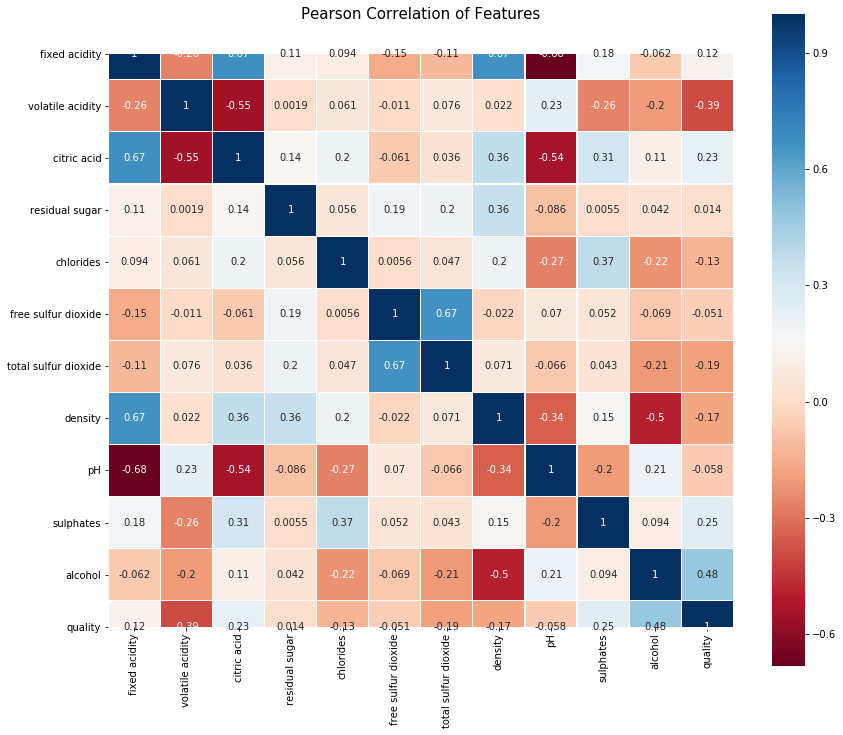

In [17]:
correlations = winred.corr()
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(correlations, linewidths = 0.1, vmax = 1, square = True, cmap = colormap, linecolor = 'white', annot = True)

**Comment:** No Feature is strongly correlated with `quality`, weak correlations exist with and  `alcohol` and `volatile acidity`
- *Could it be surmissed that higher alcohol strengths and lower volatile acidity provide indications of good wine quality?* 

### 1.3 Base Line Models
Linear Regression models with :

**A)** With All Features <br>
**B)** With All Features without 1D outliers <br>
**C)** With `Alcohol` and `volatile acidity` 

#### Data Standardization and Train - Test Split (75:25)

In [23]:
train_rmses = []
test_rmses  = []

num_random_states = 20
rmse = lambda y,pred: np.sqrt(mse(y,pred))

#Each model will be generated 20 times with different random splits each time
for i in range(num_random_states):
    
    #data with outliers
    X_train, X_test, y_train, y_test = train_test_split(
                                X_standard_np, y_np, test_size=0.25, random_state=3*i+i)

    #data exluding outliers
    X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(
                                X_standard_np[outlier_indices], y_np[outlier_indices],
                                test_size=0.25, random_state=3*i+i)
    
    if i == 1:
        print(f"Shape of X_train: {X_train.shape}")
        print(f"Shape of X_test:  {X_test.shape}")
        print(f"Shape of y_train: {y_train.shape}")
        print(f"Shape of y_test:  {y_test.shape}\n")

        print(f"Shape of X_train_out ,excluding outliers: {X_train_out.shape}")
        print(f"Shape of X_test_out:  {X_test_out.shape}")
        print(f"Shape of y_train_out: {y_train_out.shape}")
        print(f"Shape of y_test_out:  {y_test_out.shape}\n")

    #Model A
    reg = LR().fit(X_train,y_train)
    train_rmse_a = rmse(y_train,reg.predict(X_train))
    test_rmse_a  = rmse(y_test,reg.predict(X_test))
    
    #Model B
    reg = LR().fit(X_train_out,y_train_out)
    train_rmse_b = rmse(y_train_out,reg.predict(X_train_out))
    test_rmse_b  =  rmse(y_test_out,reg.predict(X_test_out))
    
    #Model C
    reg = LR().fit(X_train[:,[1,10]],y_train)
    train_rmse_c = rmse(y_train,reg.predict(X_train[:,[1,10]]))
    test_rmse_c  = rmse(y_test,reg.predict(X_test[:,[1,10]]))
    
    #Store tuple of rmses for each random split
    train_rmses.append((train_rmse_a,train_rmse_b,train_rmse_c))
    test_rmses.append((test_rmse_a,test_rmse_b,test_rmse_c))

#Find the mean RMSE of all splits
mean_train_rmse_a, mean_train_rmse_b, mean_train_rmse_c = (sum(i)/len(i) for i in zip(*train_rmses))
mean_test_rmse_a, mean_test_rmse_b, mean_test_rmse_c = (sum(i)/len(i) for i in zip(*test_rmses))

    
print(f"After {num_random_states} Random Train-Test Splits, Average values are presented below:\n")
print(f"Average Train RMSE with all features {mean_train_rmse_a}")
print(f"Averge Test RMSE with all features {mean_test_rmse_a}\n")

print(f"Average Train RMSE with all features and without outliers {mean_train_rmse_b}")
print(f"Average Test RMSE with all features and without outliers {mean_test_rmse_b}\n")

print(f"Average Train RMSE with Alcohol and Volatile Acidity {mean_train_rmse_c}")
print(f"Average Test RMSE with Alcohol and Volatile Acidity {mean_test_rmse_c}\n")

print("Test RMSE without outliers is better: ",mean_test_rmse_b < mean_test_rmse_a)
print("Absolute Difference between Test RMSE with and without outliers: ",np.abs(mean_test_rmse_b-mean_test_rmse_a))

Shape of X_train: (1199, 11)
Shape of X_test:  (400, 11)
Shape of y_train: (1199,)
Shape of y_test:  (400,)

Shape of X_train_out: (1093, 11)
Shape of X_test_out:  (365, 11)
Shape of y_train_out: (1093,)
Shape of y_test_out:  (365,)

After 20 Random Train-Test Splits, Average values are presented below:

Average Train RMSE with all features 0.6433501777026462
Averge Test RMSE with all features 0.6558054057688338

Average Train RMSE with all features and without outliers 0.6310086459360035
Average Test RMSE with all features and without outliers 0.6419275035706173

Average Train RMSE with Alcohol and Volatile Acidity 0.6670581105226642
Average Test RMSE with Alcohol and Volatile Acidity 0.6683332468277816

Test RMSE without outliers is better:  True
Absolute Difference between Test RMSE with and without outliers:  0.013877902198216496


**Conclusion:**
Inspecting the Results:
- Model was overfitting with outliers present
- Performance of the model without outliers was improved

**Modelling will proceed without Outliers**

## 2.0  Backward Stepwise Regression